In [1]:
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, InputLayer, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import numpy as np
import math
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
raw_train_path = 'TrainingData/' # raw training data
raw_test_path = 'TestData/' # raw testing data

pp_tr_path = 'PreppedTrainingData/' # preprocessed training data folder
pp_tr_session = 'tr_session_' # prefix for preprocessed training data for each session
pp_tr_final = 'pp_tr.csv' # prefix for final training data

pp_te_path = 'PreppedTestData/' # preprocessed test data folder
pp_te_session = 'session_' # prefix for preprocessed test data for each session
pp_te_final = 'pp_te.csv' # prefix for final test data

tr_features_folder = "TrainingFeatures/" # Here training data with features calculated are stored

acc_gyro_freq = 40
label_freq = 10

sample_p_label = acc_gyro_freq//label_freq # sample per label

time_window = 1 # time frame we will look at - unit (seconds)

row_p_window = time_window*acc_gyro_freq # how many samples fit in the time window


In [34]:
def extract_session_ids(path):
    files = os.listdir(path)
#     print("File Count: " + str(len(files)))
    session_ids = []
    for f in files:
        if f != '.DS_Store':
#             print(f)
            temp = f.split('subject_')[1].split('__')[0]
            if temp not in session_ids:
                session_ids.append(temp)
#     print("Session Count: " + str(len(session_ids)))
#     print(session_ids)
    return session_ids

In [11]:
# prepare training or testing - for each session there are 4 required files
def prepData(raw_data_folder, prepped_data_folder, session_prefix, final_prefix):
    session_ids = extract_session_ids(raw_data_folder)
    final_data = pd.DataFrame()
    for i in range(0,len(session_ids)):
        sid = session_ids[i]
        x_time_path = raw_data_folder + "subject_" + sid + "__x_time.csv"
        x_path =  raw_data_folder + "subject_" + sid + "__x.csv"
        y_time_path = raw_data_folder + "subject_" + sid + "__y_time.csv"
        y_path = raw_data_folder + "subject_" + sid + "__y.csv"

        # read the files 
        x = pd.read_csv(x_path, header = None, names=["xa","ya","za","xg","yg","zg"])
        x["x_time"] = pd.read_csv(x_time_path, header = None, names=["x_time"])
        y = pd.read_csv(y_time_path, header = None, names = ["y_time"])
        y["label"] = pd.read_csv(y_path, header = None, names = ["label"])
        
#         print(len(x)/len(y))
#         print(x.head())
#         print(y.head())
        
        # merge labels with accelarometer and gyroscope observation - for each sample_p_label rows of features 1 label is used
        y_time = []
        y_label = []
        session = [i]*len(x)           
        ind = 0
        counter = 1
        for row in x.itertuples():
            y_row = y.iloc[ind]
            y_time.append(y_row.y_time)
            y_label.append(y_row.label)
            
            if counter < sample_p_label:
                counter = counter + 1
            else:
                if ind + 1 < len(y):
                    ind = ind + 1
                counter = 1
        x["y_time"] = y_time
        x["label"] = y_label
        x["label"] = x["label"].astype('category')
        x["session"] = session
        final_data = pd.concat([final_data,x])
        # create files for preprocessed data for each session
        file_path = prepped_data_folder + session_prefix + sid + '.csv'
        print(file_path)
        x.to_csv(file_path,index=False)
    final_data.to_csv(prepped_data_folder + final_prefix, index=False)

In [72]:
# prepare train data + visualize
prepData(raw_train_path, pp_tr_path, pp_tr_session,pp_tr_final)

PreppedTrainingData/tr_session_006_01.csv
PreppedTrainingData/tr_session_001_08.csv
PreppedTrainingData/tr_session_001_07.csv
PreppedTrainingData/tr_session_006_03.csv
PreppedTrainingData/tr_session_007_04.csv
PreppedTrainingData/tr_session_004_02.csv
PreppedTrainingData/tr_session_001_01.csv
PreppedTrainingData/tr_session_003_02.csv
PreppedTrainingData/tr_session_001_04.csv
PreppedTrainingData/tr_session_008_01.csv
PreppedTrainingData/tr_session_002_02.csv
PreppedTrainingData/tr_session_001_05.csv
PreppedTrainingData/tr_session_005_02.csv
PreppedTrainingData/tr_session_007_01.csv
PreppedTrainingData/tr_session_007_02.csv
PreppedTrainingData/tr_session_007_03.csv
PreppedTrainingData/tr_session_005_01.csv
PreppedTrainingData/tr_session_002_01.csv
PreppedTrainingData/tr_session_003_01.csv
PreppedTrainingData/tr_session_002_04.csv
PreppedTrainingData/tr_session_001_03.csv
PreppedTrainingData/tr_session_001_02.csv
PreppedTrainingData/tr_session_004_01.csv
PreppedTrainingData/tr_session_006

In [21]:
# utility function to create features
def dist_vector(x1,y1,z1,x2,y2,z2): # distance between two vectors
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
def len_vec(x,y,z): # length of vector
    return math.sqrt(x*x+y*y+z*z)
def angle_vector(x1,y1,z1,x2,y2,z2): # cosine of angle
    len1 = len_vec(x1,y1,z1)
    len2 = len_vec(x2,y2,z2)
    if len1 == 0 or len2 == 0:
        return 0 # need to decide on this later
    return (x1*x2+y1*y2+z1*z2)/(len1*len2) # what will happen if the denominator is zero
def create_features(data_folder, dest_folder, all_session_file, use_prev_label=False, file_type="Train"):
    files = os.listdir(data_folder)
    all_sessions_feat = pd.DataFrame() # features for all sessions
    ts_feat_count = (row_p_window-1)*4 # time sensitive feature count - 4 features for each consecutive row pairs

    for f in files:
        print(f)
        df = pd.read_csv(data_folder + f)
        if file_type == "Test":
            df = pd.read_csv(data_folder + f, names=["xa","ya","za","xg","yg","zg"]) 
        
        # each row contains session number + features + label for previous row + target label
        prev_row = None
        prev_features = None
        for row in df.itertuples():
            features = []
            if file_type == "Train":
                features.append(row.session)
            # time sensitive features---------------------------------
            # step 1: initialize the time sensitive feature list
            ts_features = [0]*ts_feat_count
            if prev_features is not None:
                ts_features = prev_features
            # step 2: remove the first four features
            ts_features = ts_features[4:]
            # step 3: add the new four features at the end
            if prev_row is None:
                # 0,0,0 is the reference point - don't know if it's the right thing to do
                dacc = dist_vector(0,0,0,row.xa,row.ya,row.za) # distance between accelarator vectors
                aacc = angle_vector(0,0,0,row.xa,row.ya,row.za) # angle between accelerator vectors
                dgyro = dist_vector(0,0,0,row.xg,row.yg,row.zg) # distance between gyroscope vectors
                agyro = angle_vector(0,0,0,row.xg,row.yg,row.zg) # angle between gyroscope vectors
                ts_features.extend([dacc, aacc, dgyro, agyro])
            else:
                dacc = dist_vector(prev_row.xa,prev_row.ya,prev_row.za,row.xa,row.ya,row.za) # distance between accelarator vectors
                aacc = angle_vector(prev_row.xa,prev_row.ya,prev_row.za,row.xa,row.ya,row.za) # angle between accelerator vectors
                dgyro = dist_vector(prev_row.xg,prev_row.yg,prev_row.zg,row.xg,row.yg,row.zg) # distance between gyroscope vectors
                agyro = angle_vector(prev_row.xg,prev_row.yg,prev_row.zg,row.xg,row.yg,row.zg) # angle between gyroscope vectors
                ts_features.extend([dacc, aacc, dgyro, agyro])
            # step 4: add all the time sensitive features
            features.extend(ts_features)
            #---------------------------------------------------------
            
            if use_prev_label: # using previous row label as a feature could be problematic for test data
                if prev_row is None:
                    features.append(row.label) # if it is the first row use the label of this row
                else:
                    features.append(prev_row.label)
                    
            # Finally add the label
            if file_type == "Train":
                features.append(row.label)
            # add row of features to the features file for a session
            features_df = pd.DataFrame([features])
            features_df.to_csv(dest_folder + f,mode='a',header=None,index=False) # features for a session
            
            # add row of features to the features file for all sessions
            if file_type == "Train":
                features_df.to_csv(dest_folder + all_session_file,mode='a',header=None,index=False)
            
            prev_row = row
            prev_features = ts_features        
        

In [26]:
# create features
create_features(pp_tr_path, tr_features_folder, pp_tr_final, False, "Train")

tr_session_002_01.csv
tr_session_002_03.csv
tr_session_002_02.csv
.DS_Store
tr_session_002_05.csv
tr_session_002_04.csv
tr_session_004_02.csv
tr_session_004_01.csv
tr_session_008_01.csv
tr_session_006_01.csv
tr_session_001_08.csv
tr_session_006_02.csv
tr_session_006_03.csv
tr_session_003_02.csv
tr_session_001_07.csv
tr_session_001_06.csv
tr_session_003_03.csv
tr_session_003_01.csv
tr_session_001_04.csv
tr_session_001_05.csv
tr_session_001_01.csv
tr_session_001_02.csv
tr_session_001_03.csv
tr_session_005_01.csv
tr_session_007_04.csv
tr_session_005_03.csv
tr_session_005_02.csv
tr_session_007_03.csv
tr_session_007_02.csv
tr_session_007_01.csv


In [11]:
# sampling
train_data_w_feature = pd.read_csv(tr_features_folder + pp_tr_final, header = None)
columns = len(train_data_w_feature.columns)
X_train = train_data_w_feature.iloc[:,1:columns-1]
y_train = train_data_w_feature.iloc[:,columns-1]
counter = Counter(y_train)
print("Before oversampling")
print(counter)
print(len(X_train))
print(len(y_train))
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(y_train)
print("After oversampling")
print(len(X_train))
print(len(y_train))
print(counter)

Before oversampling
Counter({0.0: 1006926, 3.0: 206436, 2.0: 73068, 1.0: 55216})
1341646
1341646
After oversampling
4027704
4027704
Counter({0.0: 1006926, 1.0: 1006926, 2.0: 1006926, 3.0: 1006926})


In [17]:
input_dim = columns-2
output_dim = 4
lr=0.001
def simpleNN(num_hidden_layers, num_neurons):
    # input layer -> hidden layer -> hidden layer -> output layer
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=input_dim, activation='relu')) # input layer
    for i in range(0,num_hidden_layers):
        model.add(Dense(num_neurons, activation='relu')) # hidden layers
        
    model.add(Dense(output_dim, activation='softmax')) # output layer
    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model

In [45]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
    # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [20]:
# hyperparameter tuning
tuned_model = KerasClassifier(build_fn = simpleNN, epochs=20, verbose = 1)
# define hyperparameter options
num_hidden_layers = [1, 2, 3, 4]
num_neurons = [100, 250, 500]
param_grid = dict(num_hidden_layers = num_hidden_layers, num_neurons = num_neurons)
# prepare the grid
grid = GridSearchCV(estimator = tuned_model, param_grid = param_grid, cv=3)
# fit the grid
hot_y_train = np_utils.to_categorical(y_train)
grid_search_result = grid.fit(X_train, hot_y_train)
# best params
print("Best Score " + str(grid_search_result.best_score_) + "with " + str(grid_search_result.best_params_))

Epoch 1/20
2685136/2685136 [==============================] - 84s 31us/step - loss: 0.1294 - accuracy: 0.9546
Epoch 2/20
2685136/2685136 [==============================] - 75s 28us/step - loss: 0.0763 - accuracy: 0.9736
Epoch 3/20
2685136/2685136 [==============================] - 76s 28us/step - loss: 0.0643 - accuracy: 0.9780
Epoch 4/20
2685136/2685136 [==============================] - 75s 28us/step - loss: 0.0582 - accuracy: 0.9801
Epoch 5/20
2685136/2685136 [==============================] - 75s 28us/step - loss: 0.0538 - accuracy: 0.9818
Epoch 6/20
2685136/2685136 [==============================] - 75s 28us/step - loss: 0.0511 - accuracy: 0.9828
Epoch 7/20
2685136/2685136 [==============================] - 76s 28us/step - loss: 0.0487 - accuracy: 0.9836
Epoch 8/20
2685136/2685136 [==============================] - 75s 28us/step - loss: 0.0474 - accuracy: 0.9842
Epoch 9/20
2685136/2685136 [==============================] - 74s 28us/step - loss: 0.0461 - accuracy: 0.98471s - loss:


2685136/2685136 [==============================] - 212s 79us/step - loss: 0.3540 - accuracy: 0.8630
Epoch 5/20
2685136/2685136 [==============================] - 187s 70us/step - loss: 0.3479 - accuracy: 0.8661
Epoch 6/20
2685136/2685136 [==============================] - 183s 68us/step - loss: 0.3424 - accuracy: 0.8688
Epoch 7/20
2685136/2685136 [==============================] - 179s 67us/step - loss: 0.3390 - accuracy: 0.8706
Epoch 8/20
2685136/2685136 [==============================] - 179s 67us/step - loss: 0.3365 - accuracy: 0.8720
Epoch 9/20
2685136/2685136 [==============================] - 180s 67us/step - loss: 0.3338 - accuracy: 0.8733
Epoch 10/20
2685136/2685136 [==============================] - 180s 67us/step - loss: 0.3323 - accuracy: 0.8744
Epoch 11/20
2685136/2685136 [==============================] - 180s 67us/step - loss: 0.3313 - accuracy: 0.8749
Epoch 12/20
2685136/2685136 [==============================] - 182s 68us/step - loss: 0.3299 - accuracy: 0.8755
Epoch 13/

2685136/2685136 [==============================] - 82s 31us/step - loss: 0.0495 - accuracy: 0.9843:  - ETA: 1:21 - E - ETA: 1:13 - l - ETA: 1:12 - loss: 0.0487 - accura - ETA: 1:12 - loss: 0.0487 - accuracy:  - ETA: 1:12 - lo - ETA: 47s - loss: 0.0488 - accuracy: 0. - ETA: 46s - loss: 0.0489 - accur - ETA: 46s - loss: 0.0488 - accura - ETA: 45s - loss: 0.0488 - accuracy: 0.98 - ETA: 45s - loss: 0.0488 - acc - ETA: 44s - loss: 0.0489 - accuracy: 0 - ETA: 44s - loss: 0.0489 - accuracy: 0.98 - ETA: 44 - ETA: 40s - loss: 0.0488 - accuracy:  - ETA: 40s - loss: 0.0488 - accura - ETA: 39s - loss: 0.0487 - acc - ETA: 39 - ETA: 37 - ETA: 35s - loss - ETA: 27s - loss: 0.0490 -  - ETA: 26s - loss: 0.0490 - accuracy: 0. - ETA: 26s - loss: 0.0491  - ETA: 25s - loss: 0.0490 - accuracy - ETA: 25s - loss: 0.0490 - accuracy: - ETA: 24s - loss: 0.0491 - accuracy - ETA: 24s - loss: 0.0490 - accuracy: 0 - ETA: - ETA: 22s - loss:  - ETA: 20s - loss: 0.0495 -  - ETA: 20s - loss: 0. - ETA: 1 - ETA: 10s - los

2685136/2685136 [==============================] - 81s 30us/step - loss: 0.3421 - accuracy: 0.8689: 1: - ETA: 1:09 - loss: 0.3466 - accuracy: 0.86  - ETA: 55s - loss:  - ETA: 53s - loss: 0. - ETA: 43s - loss: 0.3413 - accuracy:  - ETA: 43s - loss: 0.3412 - accuracy: 0. - ETA: 42s - loss: 0.3413 - - ETA: 42s - loss: 0.3411 - accuracy: 0.868 - E  - ETA:  - ETA - ETA: 22s - loss: 0.3435 - accuracy: 0.86 - ETA: 22s - loss: 0.3435  - ETA: 21s - loss: 0.3 - ETA: 2 - ETA: 6s - loss: 0.3426 - accuracy: 0.86 - ETA: 6s - loss: 0.3426 - accuracy: 0. - ETA: 6s - loss: 0.3 - ETA - ETA: 3s - loss: 0.3424  - ETA: 
Epoch 12/20
2685136/2685136 [==============================] - 81s 30us/step - loss: 0.3377 - accuracy: 0.8696: 1:21 - loss: 0.3377  - ETA: 1:20 - loss: 0.3356  - ETA: 1:19 - los - ETA: 1:11 - - ETA: 59s - loss: 0.3363 - acc - ETA: 59s - los - ETA: 57s - loss: 0.3391 - a - ETA: 56s - loss - ETA: 55s - loss: 0.3390 -  - ETA: 54s - loss: 0.3388 - accuracy: 0. - ETA: 54s - loss: 0.3387 - a - E

2685136/2685136 [==============================] - 104s 39us/step - loss: 0.3724 - accuracy: 0.8518
Epoch 3/20
2685136/2685136 [==============================] - 103s 39us/step - loss: 0.3458 - accuracy: 0.8648
Epoch 4/20
2685136/2685136 [==============================] - 103s 39us/step - loss: 0.3314 - accuracy: 0.8722
Epoch 5/20
2685136/2685136 [==============================] - 104s 39us/step - loss: 0.3207 - accuracy: 0.8767
Epoch 6/20
2685136/2685136 [==============================] - 103s 38us/step - loss: 0.3125 - accuracy: 0.8812
Epoch 7/20
2685136/2685136 [==============================] - 103s 38us/step - loss: 0.3051 - accuracy: 0.8843
Epoch 8/20
2685136/2685136 [==============================] - 104s 39us/step - loss: 0.3002 - accuracy: 0.8867
Epoch 9/20
2685136/2685136 [==============================] - 103s 38us/step - loss: 0.2960 - accuracy: 0.8886
Epoch 10/20
2685136/2685136 [==============================] - 103s 38us/step - loss: 0.2930 - accuracy: 0.8905
Epoch 11/20

2685136/2685136 [==============================] - 382s 142us/step - loss: 0.2727 - accuracy: 0.8991
Epoch 14/20
2685136/2685136 [==============================] - 365s 136us/step - loss: 0.2709 - accuracy: 0.9005
Epoch 15/20
2685136/2685136 [==============================] - 372s 139us/step - loss: 0.2665 - accuracy: 0.9018
Epoch 16/20
2685136/2685136 [==============================] - 371s 138us/step - loss: 0.2653 - accuracy: 0.9026
Epoch 17/20
2460064/2685136 [==========================>...] - ETA: 32s - loss: 0.2618 - accuracy: 0.9039

KeyboardInterrupt: 

In [22]:
print(len(X_train))
print(len(y_train))

4027704
4027704


In [23]:
# Training and Testing after Oversampling
# split into train and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25)
hot_y_train = np_utils.to_categorical(y_tr)
hot_y_val = np_utils.to_categorical(y_val)
# create the model
# base_model = simpleNN(grid_search_result.best_params_['num_hidden_layers'],grid_search_result.best_params_['num_neurons']) # columns-2 features and 4 possible classes
base_model = simpleNN(2, 100)
# fit the keras model on the dataset
hist = base_model.fit(X_tr, hot_y_train, batch_size=32, epochs=20, validation_data=(X_val, hot_y_val),verbose=1)

Train on 3020778 samples, validate on 1006926 samples
Epoch 1/20
3020778/3020778 [==============================] - 107s 35us/step - loss: 0.4084 - accuracy: 0.8340 - val_loss: 0.3540 - val_accuracy: 0.8596
Epoch 2/20
3020778/3020778 [==============================] - 106s 35us/step - loss: 0.3329 - accuracy: 0.8684 - val_loss: 0.3161 - val_accuracy: 0.8772
Epoch 3/20
3020778/3020778 [==============================] - 105s 35us/step - loss: 0.3140 - accuracy: 0.8771 - val_loss: 0.3177 - val_accuracy: 0.8779
Epoch 4/20
3020778/3020778 [==============================] - 109s 36us/step - loss: 0.3053 - accuracy: 0.8814 - val_loss: 0.2986 - val_accuracy: 0.8839
Epoch 5/20
3020778/3020778 [==============================] - 105s 35us/step - loss: 0.3020 - accuracy: 0.8832 - val_loss: 0.3074 - val_accuracy: 0.8834
Epoch 6/20
3020778/3020778 [==============================] - 106s 35us/step - loss: 0.2978 - accuracy: 0.8854 - val_loss: 0.2994 - val_accuracy: 0.8853
Epoch 7/20
3020778/3020778 [

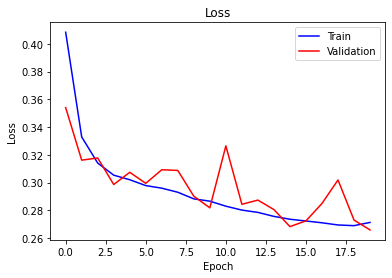

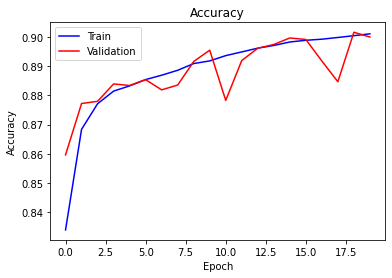

In [24]:
plot_history(hist)

In [25]:
base_model.save("base_model_nn.model")

In [23]:
# Create Features for Test Data
data_folder = "TestData/x/"
dest_folder = "TestFeatures/" 
create_features(data_folder, dest_folder, "", False, "Test")

subject_012_01__x.csv
subject_009_01__x.csv
subject_010_01__x.csv
subject_011_01__x.csv


In [27]:
# Create Test Label
dest_folder = "TestFeatures/"
test_session_ids = extract_session_ids(dest_folder)
for i in range(0,len(test_session_ids)):
    sid = test_session_ids[i]
    x_path =  dest_folder + "subject_" + sid + "__x.csv"
    y_path = "TestLabel/" + "subject_" + sid + "__y.csv"

    x = pd.read_csv(x_path, header = None)
    predY = base_model.predict(x)
    y = np.argmax(predY, axis=1)
    
    pd.DataFrame(y).to_csv(y_path,index=False)

In [ ]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,classification_report
# prediction result for validation set
valPredY = base_model.predict(X_val)
valPredY = np.argmax(valPredY, axis=1)
# New Model Evaluation metrics
print("Overall Test Performance:")
print('Accuracy Score : ' + str(accuracy_score(y_val,valPredY)))
print('Precision Score : ' + str(precision_score(y_val,valPredY,average='micro')))
print('Recall Score : ' + str(recall_score(y_val,valPredY,average='micro')))
print('F1 Score : ' + str(f1_score(y_val,valPredY,average='micro')))
print("classification Report:")
print(classification_report(y_val, valPredY, target_names=["Ground(0)", "Upstairs(1)", "Downstairs(2)", "Grass(3)"]))


In [ ]:
# preprocessing steps

In [9]:
# downsample to match label frequency - time warping (downsample)
warped_data_folder = "warped_data/"
session_files = os.listdir(pp_tr_path)
for file in session_files:
    df = pd.read_csv(pp_tr_path + file)
    warped_data = pd.DataFrame()
    rows = len(df)
    start = 1
    while start < rows:
        warped_data = warped_data.append(df.iloc[start], ignore_index=True, sort = False)
        
        start = start + 4
        
    warped_data.to_csv(warped_data_folder+file, index = False)


In [11]:
# fix data
target_folder = 'warped_noheader_sorted/'
warped_data_files = os.listdir(warped_data_folder)
for file in warped_data_files:
    if file != '.DS_Store':
        print(warped_data_folder+file)
        df_old = pd.read_csv(warped_data_folder+file)
        df_new = df_old[['xa','ya','za','xg','yg','zg','label']]
        df_new.to_csv(target_folder+file, index = False, header=None)


warped_data/tr_session_002_01.csv
warped_data/tr_session_002_03.csv
warped_data/tr_session_002_02.csv
warped_data/tr_session_002_05.csv
warped_data/tr_session_002_04.csv
warped_data/tr_session_004_02.csv
warped_data/tr_session_004_01.csv
warped_data/tr_session_008_01.csv
warped_data/tr_session_006_01.csv
warped_data/tr_session_001_08.csv
warped_data/tr_session_006_02.csv
warped_data/tr_session_006_03.csv
warped_data/tr_session_003_02.csv
warped_data/tr_session_001_07.csv
warped_data/tr_session_001_06.csv
warped_data/tr_session_003_03.csv
warped_data/tr_session_003_01.csv
warped_data/tr_session_001_04.csv
warped_data/tr_session_001_05.csv
warped_data/tr_session_001_01.csv
warped_data/tr_session_001_02.csv
warped_data/tr_session_001_03.csv
warped_data/tr_session_005_01.csv
warped_data/tr_session_007_04.csv
warped_data/tr_session_005_03.csv
warped_data/tr_session_005_02.csv
warped_data/tr_session_007_03.csv
warped_data/tr_session_007_02.csv
warped_data/tr_session_007_01.csv


In [49]:
# convert each data point -> time series
def gen_time_series(window, data_folder, label_type = 'mid'): # label type can be middle or at the end
    
    x_arr = list()
    y_arr = list()
    
    files = os.listdir(data_folder)
    for file in files:
        if file != '.DS_Store': 
            print(file)
            df = pd.read_csv(data_folder+file)

            df_len = len(df)
            start = 0
            while start + window - 1 < df_len:
                data_window = df.iloc[start:start + window,0:6]
                data_window = np.asarray(data_window)
                x_arr.append(data_window)

                ind = start + (window//2)
                if label_type != 'mid':
                    ind = start + window - 1

                y_arr.append(int(df.iat[ind,6]))

                start = start + 1
            
    X = np.asarray(x_arr)
    Y = np.asarray(y_arr)
    return X,Y # X and Y are numpy array

In [50]:
target_folder = 'warped_noheader_sorted/'
X,Y = gen_time_series(30,target_folder)
print(X.shape)
print(Y.shape)

tr_session_002_01.csv
tr_session_002_03.csv
tr_session_002_02.csv
tr_session_002_05.csv
tr_session_002_04.csv
tr_session_004_02.csv
tr_session_004_01.csv
tr_session_008_01.csv
tr_session_006_01.csv
tr_session_001_08.csv
tr_session_006_02.csv
tr_session_006_03.csv
tr_session_003_02.csv
tr_session_001_07.csv
tr_session_001_06.csv
tr_session_003_03.csv
tr_session_003_01.csv
tr_session_001_04.csv
tr_session_001_05.csv
tr_session_001_01.csv
tr_session_001_02.csv
tr_session_001_03.csv
tr_session_005_01.csv
tr_session_007_04.csv
tr_session_005_03.csv
tr_session_005_02.csv
tr_session_007_03.csv
tr_session_007_02.csv
tr_session_007_01.csv
(334543, 30, 6)
(334543,)


In [51]:
# under sample
counter = Counter(Y)
print("Before oversampling")
print(counter)
# create the undersampler
undersample = RandomUnderSampler(sampling_strategy='majority')
# transform the dataset
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # this method takes only 2d array
X, Y = undersample.fit_resample(X, Y)
X, Y = undersample.fit_resample(X, Y)
X, Y = undersample.fit_resample(X, Y)
counter = Counter(Y)
print("After Undersampling")
print(counter)

X = X.reshape(X.shape[0], X.shape[1]//6, 6) # reshape to retain the original shape
print(X.shape)
print(Y.shape)

Before oversampling
Counter({0: 250863, 3: 51609, 2: 18267, 1: 13804})
After Undersampling
Counter({0: 13804, 1: 13804, 2: 13804, 3: 13804})
(55216, 30, 6)
(55216,)


In [52]:
# model
def simpleLSTM(timestep, features, lstm_neurons, rate_dropout, output_dim, lr):
    # input layer -> LSTM -> output layer
    
    model_LSTM = Sequential()
    # add input layer
    model_LSTM.add(InputLayer(input_shape=(timestep, features)))
    # add LSTM layer
    model_LSTM.add(LSTM(units=lstm_neurons, activation='relu'))
    # add dropout layer
    model_LSTM.add(Dropout(rate_dropout))
    # add dense layer
    model_LSTM.add(Dense(output_dim, activation='softmax')) # output layer
    # compile the keras model
    model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model_LSTM

In [53]:
# train
# split into train and validation
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=0.20)
hot_Y_train = np_utils.to_categorical(Y_tr)
hot_Y_val = np_utils.to_categorical(Y_val)
# create the model
LSTM_model = simpleLSTM(30, 6, 100, 0.1, 4, 0.001)
LSTM_model.summary()
# fit the keras model on the dataset
lstm_hist = LSTM_model.fit(X_tr, hot_Y_train, batch_size=64, epochs=50, validation_data=(X_val, hot_Y_val),verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 43,204
Trainable params: 43,204
Non-trainable params: 0
_________________________________________________________________
Train on 44172 samples, validate on 11044 samples
Epoch 1/50
44172/44172 [==============================] - 12s 280us/step - loss: 0.4446 - accuracy: 0.8189 - val_loss: 0.2446 - val_accuracy: 0.9073
Epoch 2/50
44172/44172 [==============================] - 11s 252us/step - loss: 0.2260 - accuracy: 0.9163 - val_loss: 0.1757 - val_accuracy: 0.9361
Epoch 3/50
44172/44172 [========

44172/44172 [==============================] - 12s 282us/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0839 - val_accuracy: 0.9814


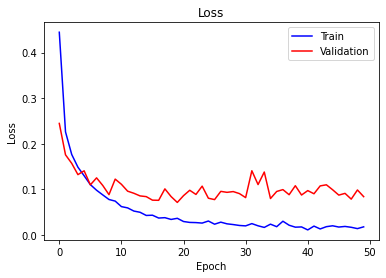

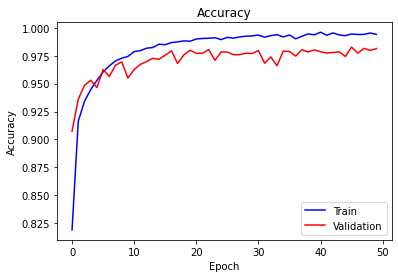

In [54]:
plot_history(lstm_hist)

In [55]:
LSTM_model.save("LSTM_model.model")

In [56]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,classification_report
# prediction result for validation set
valPredY = LSTM_model.predict(X_val)
valPredY = np.argmax(valPredY, axis=1)
# New Model Evaluation metrics
print("Overall Test Performance:")
print('Accuracy Score : ' + str(accuracy_score(Y_val,valPredY)))
print('Precision Score : ' + str(precision_score(Y_val,valPredY,average='micro')))
print('Recall Score : ' + str(recall_score(Y_val,valPredY,average='micro')))
print('F1 Score : ' + str(f1_score(Y_val,valPredY,average='micro')))
print("classification Report:")
print(classification_report(Y_val, valPredY, target_names=["Ground(0)", "Upstairs(1)", "Downstairs(2)", "Grass(3)"]))


Overall Test Performance:
Accuracy Score : 0.981437884824339
Precision Score : 0.981437884824339
Recall Score : 0.981437884824339
F1 Score : 0.981437884824339
classification Report:
               precision    recall  f1-score   support

    Ground(0)       0.95      0.97      0.96      2762
  Upstairs(1)       0.99      0.99      0.99      2738
Downstairs(2)       0.99      0.99      0.99      2768
     Grass(3)       0.99      0.96      0.98      2776

     accuracy                           0.98     11044
    macro avg       0.98      0.98      0.98     11044
 weighted avg       0.98      0.98      0.98     11044



In [ ]:
# testing

In [4]:
# undersampling to match label frequency
warped_test_folder = "warped_test_data/"
test_session_files = os.listdir(raw_test_path + 'x/')
for file in test_session_files:
    if file != '.DS_Store':
        print(file)
        df = pd.read_csv(raw_test_path + 'x/' + file, header = None, names=["xa","ya","za","xg","yg","zg"])
        warped_test_data = pd.DataFrame()
        rows = len(df)
        start = 1
        while start < rows:
            warped_test_data = warped_test_data.append(df.iloc[start], ignore_index=True, sort = False)

            start = start + 4

        warped_test_data = warped_test_data[['xa','ya','za','xg','yg','zg']]
        # manually deleted last row to exactly match label frequency
        warped_test_data = warped_test_data[:-1]
        print(len(warped_test_data))
        warped_test_data.to_csv(warped_test_folder+file, index = False, header=None)

y_time_files = ['subject_009_01__y_time.csv','subject_010_01__y_time.csv','subject_011_01__y_time.csv','subject_012_01__y_time.csv']
for file in y_time_files:
    if file != '.DS_Store':
        print(file)
        df = pd.read_csv(raw_test_path + file)
        print(len(df))

subject_012_01__x.csv
11329
subject_009_01__x.csv
9497
subject_010_01__x.csv
12269
subject_011_01__x.csv
12939
subject_009_01__y_time.csv
9497
subject_010_01__y_time.csv
12269
subject_011_01__y_time.csv
12939
subject_012_01__y_time.csv
11329


In [57]:
# funstion to prepare test time series for prediction
def gen_test_time_series(window, file_path): # label type can be middle or at the end 
    df = pd.read_csv(file_path)
    df_len = len(df)
    print(df_len)
    print(df.shape)
    x_arr = list()
    y_arr = list()
    
    current = 0
    
    required_past = window//2
    required_future = required_past-1
    
    while current < df_len:
        # define where the window starts
        start = current - required_past
        
        # extra zero rows to fill up the past
        past_padding = None
        if current - required_past < 0:
            past_padding = np.zeros([abs(current - required_past),df.shape[1]])
            start = 0
    
        # define where the window ends
        end = current + required_future
        
        # extra zero rows to fill up the future
        future_padding = None
        if end > df_len - 1:
            future_padding = np.zeros([end - (df_len-1),df.shape[1]])
            end = df_len - 1
            
        frames = list()
        if past_padding is not None:
            frames.append(past_padding)
        frames.append(np.asarray(df.iloc[start:end+1,0:df.shape[1]]))
        if future_padding is not None:
            frames.append(future_padding)
            
        data_window = np.concatenate(frames,axis=0)
        x_arr.append(data_window)

        current = current + 1
            
    X = np.asarray(x_arr)

    return X # X is numpy array

In [58]:
# prepare test data and predict
test_session_ids = extract_session_ids(warped_test_folder)
for i in range(0,len(test_session_ids)):
    sid = test_session_ids[i]
    x_path =  warped_test_folder + "subject_" + sid + "__x.csv"
    print(x_path)
    y_path = "TestLabel/" + "subject_" + sid + "__y_prediction.csv"
    
    X_test = gen_test_time_series(30,x_path)
    print("x:"+str(X_test.shape))
    
    # prediction
    predY = LSTM_model.predict(X_test)
    Y_test = np.argmax(predY, axis=1)
    print(Y_test.shape)
    pd.DataFrame(Y_test).to_csv(y_path,index=False)

warped_test_data/subject_012_01__x.csv
11328
(11328, 6)
x:(11328, 30, 6)
(11328,)
warped_test_data/subject_009_01__x.csv
9496
(9496, 6)
x:(9496, 30, 6)
(9496,)
warped_test_data/subject_010_01__x.csv
12268
(12268, 6)
x:(12268, 30, 6)
(12268,)
warped_test_data/subject_011_01__x.csv
12938
(12938, 6)
x:(12938, 30, 6)
(12938,)
